**Initialization**

In [1]:
import numpy as np

%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

**Task 1: Data set**

Training inputs shape: (60000, 28, 28)
Training labels shape: (60000,)
Test inputs shape: (10000, 28, 28)
Test labels shape: (10000,)


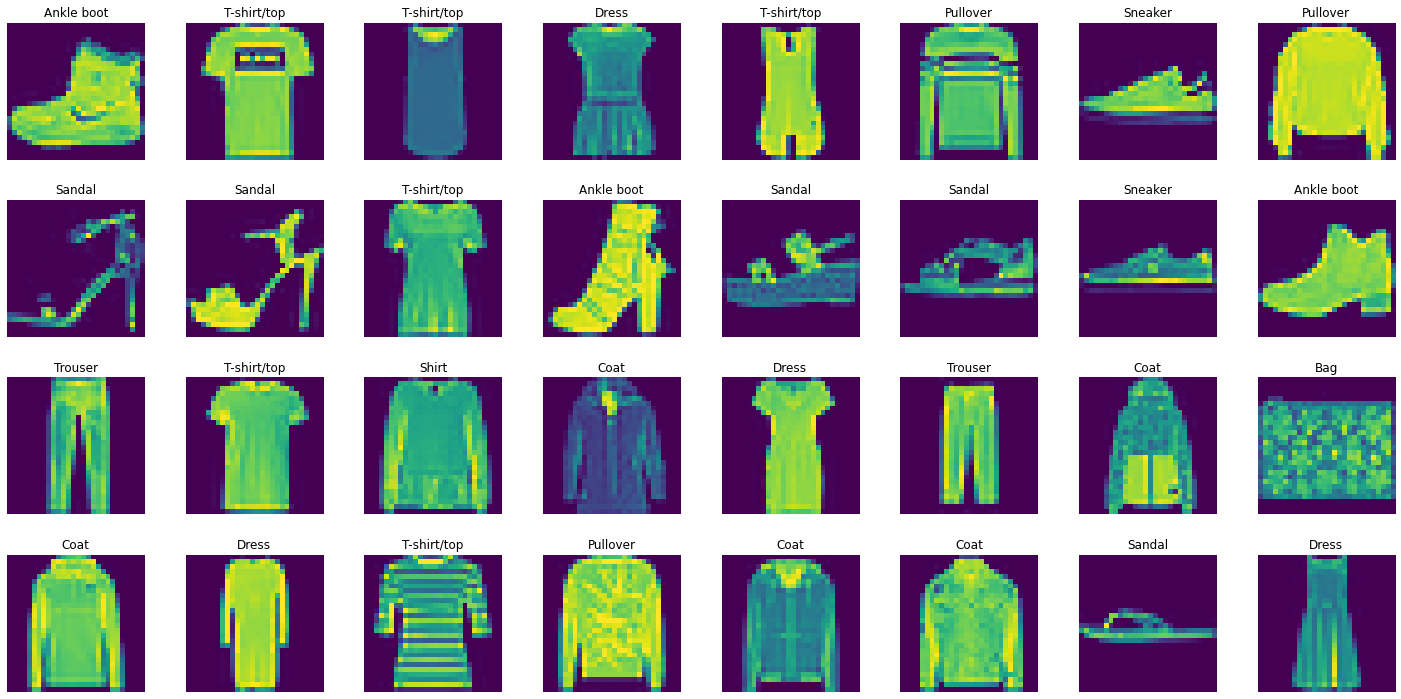

In [2]:
(training_inputs, training_labels), (test_inputs, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

print("Training inputs shape: " + str(training_inputs.shape))
print("Training labels shape: " + str(training_labels.shape))
print("Test inputs shape: " + str(test_inputs.shape))
print("Test labels shape: " + str(test_labels.shape))

label_encoding = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
fig, ax = plt.subplots(4, 8, figsize=(20,10))
fig.tight_layout()
ax = ax.flatten()
for i in range(32):
  image = training_inputs[i]
  label = label_encoding[training_labels[i]]

  ax[i].imshow(image)
  ax[i].set_title(label)
  ax[i].axis("off")

Input pipeline

In [3]:
def load_real_images(selected_class):
  (train_inputs, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

  selected_images = train_labels == selected_class
  selected_images = train_inputs[selected_images]
  selected_images = tf.expand_dims(selected_images, -1)
  selected_images = 2 * (selected_images / 255) - 1
  return selected_images


def generate_real_samples(real_images, n_samples, wasserstein = False):
  random_samples = np.random.randint(0, real_images.shape[0], n_samples)
  random_real_imgs = []
  for i in range(len(random_samples)):
    random_real_imgs.append(real_images[random_samples[i]])

  real_img_targets = tf.ones(shape = [n_samples], dtype = tf.dtypes.int8)           
  if wasserstein == True:
    real_img_targets = -1 * real_img_targets                  # -ones for Wasserstein GAN
  
  real_img_inputs_dataset = tf.data.Dataset.from_tensor_slices(random_real_imgs)
  real_img_targets_dataset = tf.data.Dataset.from_tensor_slices(real_img_targets)

  real_img_dataset = tf.data.Dataset.zip((real_img_inputs_dataset, real_img_targets_dataset))
  real_img_dataset = real_img_dataset.batch(n_samples).prefetch(n_samples)
  return real_img_dataset


def generate_latent_points(size_of_latent_space, n_samples):
  latent_spaces = tf.random.normal(shape = [size_of_latent_space * n_samples])
  latent_spaces = tf.reshape(latent_spaces, shape = [n_samples, size_of_latent_space])
  return latent_spaces


def generate_generator_samples(size_of_latent_space, n_samples, wasserstein = False):
  generator_inputs = generate_latent_points(size_of_latent_space, n_samples)

  generator_targets = tf.ones(shape = [n_samples], dtype = tf.dtypes.int8) 
  if wasserstein == True:
    generator_targets = -1 * generator_targets             # -ones for Wasserstein GAN

  generator_input_dataset = tf.data.Dataset.from_tensor_slices(generator_inputs)
  generator_target_dataset = tf.data.Dataset.from_tensor_slices(generator_targets)

  generator_dataset = tf.data.Dataset.zip((generator_input_dataset, generator_target_dataset))
  generator_dataset = generator_dataset.batch(n_samples).prefetch(n_samples)                         # No shuffling necessary, because the images are randomly generated.
  return generator_dataset


def generate_fake_samples(generator, size_of_latent_space, n_samples, wasserstein = False):
  latent_spaces = generate_latent_points(size_of_latent_space, n_samples)

  generator_input_dataset = tf.data.Dataset.from_tensor_slices(latent_spaces)  
  generator_input_dataset = generator_input_dataset.batch(n_samples).prefetch(n_samples)
  fake_imgs = []
  for input in generator_input_dataset:
    fake_img = generator(input, training = False)
    fake_imgs.append(fake_img)
  fake_imgs = tf.reshape(fake_imgs, shape = [n_samples, 28, 28, 1])                # To remove fifth dimension: [32, 28, 28, 1] instead of [1, 32, 28, 28, 1]

  fake_img_targets = tf.zeros(shape = [n_samples], dtype = tf.dtypes.int8)
  if wasserstein == True:
    fake_img_targets = tf.ones(shape = [n_samples], dtype = tf.dtypes.int8)        # ones for Wasserstein GAN

  fake_img_inputs_dataset = tf.data.Dataset.from_tensor_slices(fake_imgs)
  fake_img_targets_dataset = tf.data.Dataset.from_tensor_slices(fake_img_targets)

  fake_img_dataset = tf.data.Dataset.zip((fake_img_inputs_dataset, fake_img_targets_dataset))
  fake_img_dataset = fake_img_dataset.batch(n_samples).prefetch(n_samples)
  return fake_img_dataset

**Task 2: Model**

**Task 2.1: Basic Generative Adversarial Network (GAN)**

Class Generator -> Fertig. 

In [4]:
# Description: The class Generator defines the generator of a GAN.
class Generator(tf.keras.layers.Layer): 
  
  def __init__(self, size_of_latent_space):
    super(Generator, self).__init__()

    self.dense_layer = tf.keras.layers.Dense(size_of_latent_space, 
                                             kernel_initializer = tf.keras.initializers.RandomNormal(stddev = 0.02))
    self.activ_1 = tf.keras.activations.relu 
    self.reshape_layer = tf.keras.layers.Reshape((7, 7, 1))  

    self.transp_conv_1 = tf.keras.layers.Conv2DTranspose(filters = 128,
                                                         kernel_size = 4,                 # Even sized kernel to avoid chessboard artifacts in transposed convolutions.
                                                         strides = 2,
                                                         activation = None,
                                                         padding = 'same',
                                                         kernel_initializer = tf.keras.initializers.RandomNormal(stddev = 0.02))
    self.batch_norm_1 = tf.keras.layers.BatchNormalization()                                     
    self.activ_2 = tf.keras.activations.relu 
    self.transp_conv_2 = tf.keras.layers.Conv2DTranspose(filters = 128,
                                                         kernel_size = 4,                 # Even sized kernel to avoid chessboard artifacts in transposed convolutions.
                                                         strides = 2,
                                                         activation = None,
                                                         padding = 'same',
                                                         kernel_initializer = tf.keras.initializers.RandomNormal(stddev = 0.02))     
    self.batch_norm_2 = tf.keras.layers.BatchNormalization()                                     
    self.activ_3 = tf.keras.activations.relu 

    self.output_layer = tf.keras.layers.Conv2D(filters = 1,
                                               kernel_size = 7,
                                               strides = 1,
                                               activation = tf.keras.activations.tanh,
                                               padding = 'same',
                                               kernel_initializer = tf.keras.initializers.RandomNormal(stddev = 0.02))  

  # Description: This function conducts 
  #              The python decorator @tf.function is used to bundle multiple computations into one computational graph.
  #              @parameters: (input) x, training necessary??????????????
  #              @returns: (prediction) x
  #@tf.function
  def call(self, x, training):
    x = self.dense_layer(x)
    x = self.activ_1(x)
    x = self.reshape_layer(x)

    x = self.transp_conv_1(x)
    x = self.batch_norm_1(x, training)
    x = self.activ_2(x)
    x = self.transp_conv_2(x)
    x = self.batch_norm_2(x, training)
    x = self.activ_3(x)

    x = self.output_layer(x)
    return x    

Class Discriminator -> Fertig!

In [5]:
# Description: The class Discriminator defines the discriminator of a GAN. Two different call and init functions for basic GAN and Watergate GAN?? One class for two versions???
class Discriminator(tf.keras.layers.Layer): 
  
  def __init__(self):
    super(Discriminator, self).__init__()       

    self.conv_1 = tf.keras.layers.Conv2D(filters = 48,
                                         kernel_size = 4,
                                         strides = 2,
                                         activation = None,
                                         padding = 'same',  
                                         kernel_initializer = tf.keras.initializers.RandomNormal(),                              
                                         input_shape = (28, 28, 1))     
    self.batch_norm_1 = tf.keras.layers.BatchNormalization()                                     
    self.activ_1 = tf.keras.activations.tanh 
    self.dropout_1 = tf.keras.layers.Dropout(rate = 0.8) 
    self.conv_2 = tf.keras.layers.Conv2D(filters = 48,
                                         kernel_size = 4,
                                         strides = 2,
                                         activation = None,
                                         padding = 'same',  
                                         kernel_initializer = tf.keras.initializers.RandomNormal())
    self.batch_norm_2 = tf.keras.layers.BatchNormalization()                                     
    self.activ_2 = tf.keras.activations.tanh        

    self.flatten_layer = tf.keras.layers.Flatten()
    self.dropout_2 = tf.keras.layers.Dropout(rate = 0.5) 
    self.output_layer = tf.keras.layers.Dense(1,
                                              activation = tf.keras.activations.sigmoid)   

  # Description: This function conducts
  #              The python decorator @tf.function is used to bundle multiple computations into one computational graph.
  #              @parameters: (input) x, training necessary??????????????
  #              @returns: (prediction) x
  #@tf.function
  def call(self, x, training):
    x = self.conv_1(x)  
    x = self.batch_norm_1(x, training)                                    
    x = self.activ_1(x)
    x = self.dropout_1(x, training)
    x = self.conv_2(x)
    x = self.batch_norm_2(x, training)                                   
    x = self.activ_2(x)  

    x = self.flatten_layer(x)
    x = self.dropout_2(x, training)
    x = self.output_layer(x)
    return x                 

Wasserstein Discriminator -> Fertig.

In [6]:
# Description: The class Discriminator defines the discriminator of a GAN. Two different call and init functions for basic GAN and Watergate GAN?? One class for two versions???
class WassersteinDiscriminator(tf.keras.layers.Layer): 
  
  def __init__(self):
    super(WassersteinDiscriminator, self).__init__()       

    self.conv_1 = tf.keras.layers.Conv2D(filters = 64,
                                         kernel_size = 4,
                                         strides = 2,
                                         activation = None,
                                         padding = 'same',  
                                         kernel_initializer = tf.keras.initializers.RandomNormal(),   
                                         kernel_constraint = tf.keras.constraints.MinMaxNorm(min_value = -0.01, max_value = 0.01),
                                         bias_constraint = tf.keras.constraints.MinMaxNorm(min_value = -0.01, max_value = 0.01),                                
                                         input_shape = (28, 28, 1))     
    self.batch_norm_1 = tf.keras.layers.BatchNormalization()                                     
    self.activ_1 = tf.keras.activations.tanh  
    self.conv_2 = tf.keras.layers.Conv2D(filters = 64,
                                         kernel_size = 4,
                                         strides = 2,
                                         activation = None,
                                         padding = 'same',  
                                         kernel_initializer = tf.keras.initializers.RandomNormal(),       
                                         kernel_constraint = tf.keras.constraints.MinMaxNorm(min_value = -0.01, max_value = 0.01),
                                         bias_constraint = tf.keras.constraints.MinMaxNorm(min_value = -0.01, max_value = 0.01))
    self.batch_norm_2 = tf.keras.layers.BatchNormalization()                                     
    self.activ_2 = tf.keras.activations.tanh       

    self.flatten_layer = tf.keras.layers.Flatten()
    self.output_layer = tf.keras.layers.Dense(1,
                                              activation = None)   

  # Description: This function conducts
  #              The python decorator @tf.function is used to bundle multiple computations into one computational graph.
  #              @parameters: (input) x, training necessary??????????????
  #              @returns: (prediction) x
  #@tf.function
  def call(self, x, training):
    x = self.conv_1(x)  
    x = self.batch_norm_1(x, training)                                    
    x = self.activ_1(x)
    x = self.conv_2(x)
    x = self.batch_norm_2(x, training)                                   
    x = self.activ_2(x)  

    x = self.flatten_layer(x)
    x = self.output_layer(x)
    return x          

**Task 3: Training**

Training step functions for generator and discriminator. 

In [7]:
# Description: This function conducts a forward-step and the backpropagation. Additionally, the average training loss and accuracy is determined.
#              @parameters: model, training_data, loss_fn, optimizer, training 
#              @returns: training_loss, training_accuracy
#@tf.function
def generator_training_step(generator, discriminator, dataset, loss_fn, optimizer, gen_training = True, dis_training = False):
  training_losses = []
  for (input, target) in dataset:
    with tf.GradientTape() as tape:
      fake_img = generator(input, gen_training)   
      prediction = discriminator(fake_img, dis_training)

      current_training_loss = loss_fn(target, prediction)  
      gradients = tape.gradient(current_training_loss, generator.trainable_variables)
    optimizer.apply_gradients(zip(gradients, generator.trainable_variables))

    training_losses.append(current_training_loss.numpy())
  
  training_loss = np.mean(training_losses)
  return training_loss
  

# Description: This function conducts a forward-step and the backpropagation. Additionally, the average training loss and accuracy is determined.
#              @parameters: model, training_data, loss_fn, optimizer, training 
#              @returns: training_loss, training_accuracy
#@tf.function
def discriminator_training_step(discriminator, dataset, loss_fn, optimizer, training = True):
  training_losses = []
  for (input, target) in dataset:
    with tf.GradientTape() as tape:
      prediction = discriminator(input, training)                                                                                                      
      current_training_loss = loss_fn(target, prediction)   
      gradients = tape.gradient(current_training_loss, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(gradients, discriminator.trainable_variables))

    training_losses.append(current_training_loss.numpy())
  
  training_loss = np.mean(training_losses)
  return training_loss

Wasserstein loss function

In [8]:
def wasserstein_loss(target, prediction):
  target = tf.cast(target, dtype = tf.dtypes.float32)
  return tf.keras.backend.mean(target * prediction)

Training of classical or Wasserstein GAN

Step 0
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Step 11
Step 12
Step 13
Step 14
Step 15
Step 16
Step 17
Step 18
Step 19
Step 20
Step 21
Step 22
Step 23
Step 24
Step 25
Step 26
Step 27
Step 28
Step 29
Step 30
Step 31
Step 32
Step 33
Step 34
Step 35
Step 36
Step 37
Step 38
Step 39
Step 40
Step 41
Step 42
Step 43
Step 44
Step 45
Step 46
Step 47
Step 48
Step 49
Step 50
Step 51
Step 52
Step 53
Step 54
Step 55
Step 56
Step 57


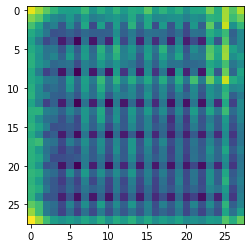

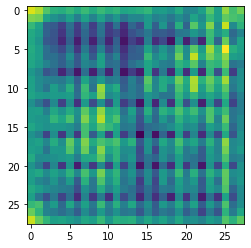

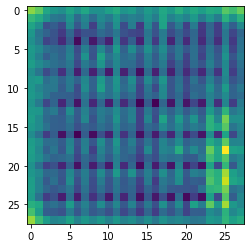

Generator loss: -0.21282412
Discriminator loss: -10.184673
Step 58
Step 59
Step 60
Step 61
Step 62
Step 63
Step 64
Step 65
Step 66
Step 67
Step 68
Step 69
Step 70
Step 71
Step 72
Step 73
Step 74
Step 75
Step 76
Step 77
Step 78
Step 79
Step 80
Step 81
Step 82
Step 83
Step 84
Step 85
Step 86
Step 87
Step 88
Step 89
Step 90
Step 91
Step 92
Step 93
Step 94
Step 95
Step 96
Step 97
Step 98
Step 99
Step 100
Step 101
Step 102
Step 103
Step 104
Step 105
Step 106
Step 107
Step 108
Step 109
Step 110
Step 111
Step 112
Step 113
Step 114
Step 115


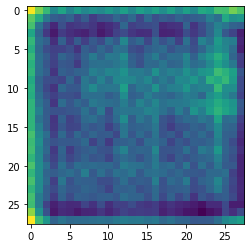

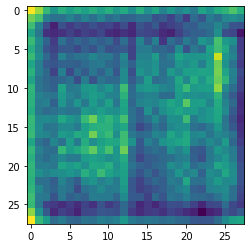

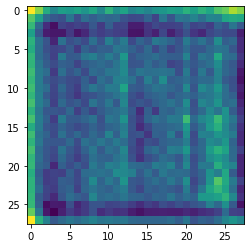

Generator loss: -5.554857
Discriminator loss: -18.37588
Step 116
Step 117
Step 118
Step 119
Step 120
Step 121
Step 122
Step 123
Step 124
Step 125
Step 126
Step 127
Step 128
Step 129
Step 130
Step 131
Step 132
Step 133
Step 134
Step 135
Step 136
Step 137
Step 138
Step 139
Step 140
Step 141
Step 142
Step 143
Step 144
Step 145
Step 146
Step 147
Step 148
Step 149
Step 150
Step 151
Step 152
Step 153
Step 154
Step 155
Step 156
Step 157
Step 158
Step 159
Step 160
Step 161
Step 162
Step 163
Step 164
Step 165
Step 166
Step 167
Step 168
Step 169
Step 170
Step 171
Step 172
Step 173


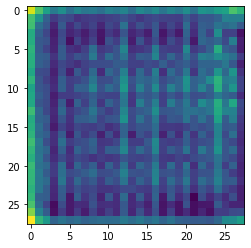

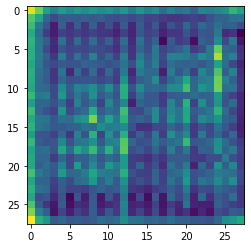

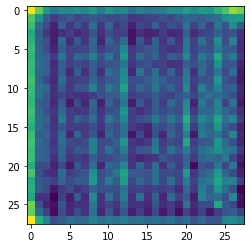

Generator loss: -46.14856
Discriminator loss: -36.084404
Step 174
Step 175
Step 176
Step 177
Step 178
Step 179
Step 180
Step 181
Step 182
Step 183
Step 184
Step 185
Step 186
Step 187
Step 188
Step 189
Step 190
Step 191
Step 192
Step 193
Step 194
Step 195
Step 196
Step 197
Step 198
Step 199
Step 200
Step 201
Step 202
Step 203
Step 204
Step 205
Step 206
Step 207
Step 208
Step 209
Step 210
Step 211
Step 212
Step 213
Step 214
Step 215
Step 216
Step 217
Step 218
Step 219
Step 220
Step 221
Step 222
Step 223
Step 224
Step 225
Step 226
Step 227
Step 228
Step 229
Step 230
Step 231


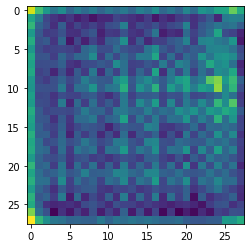

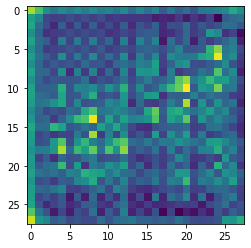

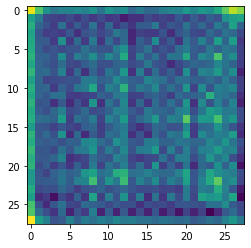

Generator loss: -86.970184
Discriminator loss: -57.828667
Step 232
Step 233
Step 234
Step 235
Step 236
Step 237
Step 238
Step 239
Step 240
Step 241
Step 242
Step 243
Step 244
Step 245
Step 246
Step 247
Step 248
Step 249
Step 250
Step 251
Step 252
Step 253
Step 254
Step 255
Step 256
Step 257
Step 258
Step 259
Step 260
Step 261
Step 262
Step 263
Step 264
Step 265
Step 266
Step 267
Step 268
Step 269
Step 270
Step 271
Step 272
Step 273
Step 274
Step 275
Step 276
Step 277
Step 278
Step 279
Step 280
Step 281
Step 282
Step 283
Step 284
Step 285
Step 286
Step 287
Step 288
Step 289


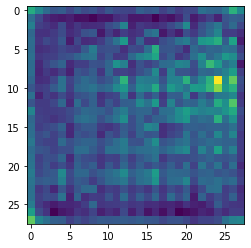

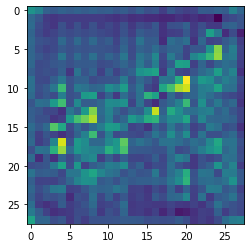

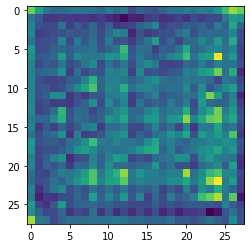

Generator loss: -107.89307
Discriminator loss: -77.13972
Step 290
Step 291
Step 292
Step 293
Step 294
Step 295
Step 296
Step 297
Step 298
Step 299
Step 300
Step 301
Step 302
Step 303
Step 304
Step 305
Step 306
Step 307
Step 308
Step 309
Step 310
Step 311
Step 312
Step 313
Step 314
Step 315
Step 316
Step 317
Step 318
Step 319
Step 320
Step 321
Step 322
Step 323
Step 324
Step 325
Step 326
Step 327
Step 328
Step 329
Step 330
Step 331
Step 332
Step 333
Step 334
Step 335
Step 336
Step 337
Step 338
Step 339
Step 340
Step 341
Step 342
Step 343
Step 344
Step 345
Step 346
Step 347


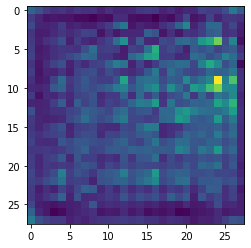

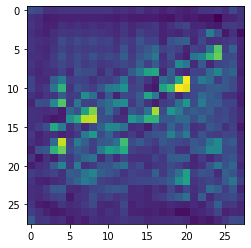

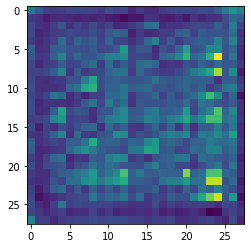

Generator loss: -114.19322
Discriminator loss: -95.033676
Step 348
Step 349
Step 350
Step 351
Step 352
Step 353
Step 354
Step 355
Step 356
Step 357
Step 358
Step 359
Step 360
Step 361
Step 362
Step 363
Step 364
Step 365
Step 366
Step 367
Step 368
Step 369
Step 370
Step 371
Step 372
Step 373
Step 374
Step 375
Step 376
Step 377
Step 378
Step 379
Step 380
Step 381
Step 382
Step 383
Step 384
Step 385
Step 386
Step 387
Step 388
Step 389
Step 390
Step 391
Step 392
Step 393
Step 394
Step 395
Step 396
Step 397
Step 398
Step 399
Step 400
Step 401
Step 402
Step 403
Step 404
Step 405


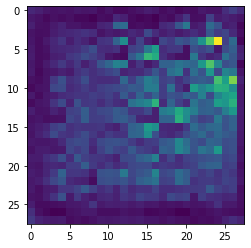

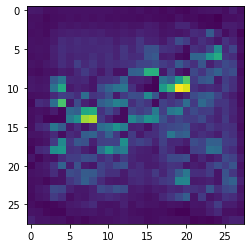

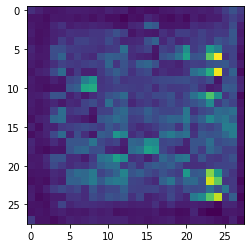

Generator loss: -105.06309
Discriminator loss: -109.61469
Step 406
Step 407
Step 408
Step 409
Step 410
Step 411
Step 412
Step 413
Step 414
Step 415
Step 416
Step 417
Step 418
Step 419
Step 420
Step 421
Step 422
Step 423
Step 424
Step 425
Step 426
Step 427
Step 428
Step 429
Step 430
Step 431
Step 432
Step 433
Step 434
Step 435
Step 436
Step 437
Step 438
Step 439
Step 440
Step 441
Step 442
Step 443
Step 444
Step 445
Step 446
Step 447
Step 448
Step 449
Step 450
Step 451
Step 452
Step 453
Step 454
Step 455
Step 456
Step 457
Step 458
Step 459
Step 460
Step 461
Step 462
Step 463


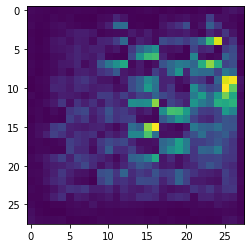

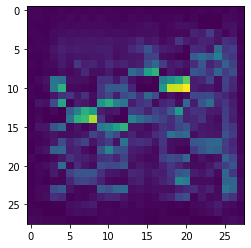

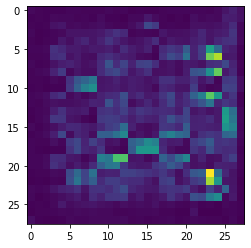

Generator loss: -89.313644
Discriminator loss: -123.90278
Step 464
Step 465
Step 466
Step 467
Step 468
Step 469
Step 470
Step 471
Step 472
Step 473
Step 474
Step 475
Step 476
Step 477
Step 478
Step 479
Step 480
Step 481
Step 482
Step 483
Step 484
Step 485
Step 486
Step 487
Step 488
Step 489
Step 490
Step 491
Step 492
Step 493
Step 494
Step 495
Step 496
Step 497
Step 498
Step 499
Step 500
Step 501
Step 502
Step 503
Step 504
Step 505
Step 506
Step 507
Step 508
Step 509
Step 510
Step 511
Step 512
Step 513
Step 514
Step 515
Step 516
Step 517
Step 518
Step 519
Step 520
Step 521


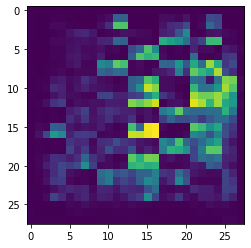

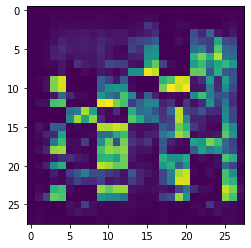

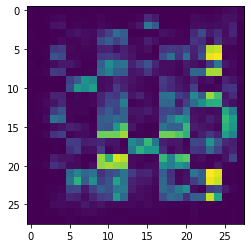

Generator loss: -43.063385
Discriminator loss: -106.72564
Step 522
Step 523
Step 524
Step 525
Step 526
Step 527
Step 528
Step 529
Step 530
Step 531
Step 532
Step 533
Step 534
Step 535
Step 536
Step 537
Step 538
Step 539
Step 540
Step 541
Step 542
Step 543
Step 544
Step 545
Step 546
Step 547
Step 548
Step 549
Step 550
Step 551
Step 552
Step 553
Step 554
Step 555
Step 556
Step 557
Step 558
Step 559
Step 560
Step 561
Step 562
Step 563
Step 564
Step 565
Step 566
Step 567
Step 568
Step 569
Step 570
Step 571
Step 572
Step 573
Step 574
Step 575
Step 576
Step 577
Step 578
Step 579


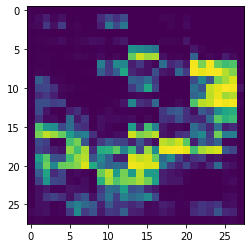

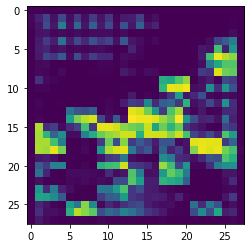

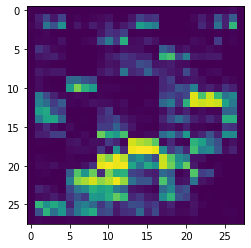

Generator loss: 65.36498
Discriminator loss: -19.312864
Step 580
Step 581
Step 582
Step 583
Step 584
Step 585
Step 586
Step 587
Step 588
Step 589
Step 590
Step 591
Step 592
Step 593
Step 594
Step 595
Step 596
Step 597
Step 598
Step 599
Step 600
Step 601
Step 602
Step 603
Step 604
Step 605
Step 606
Step 607
Step 608
Step 609
Step 610
Step 611
Step 612
Step 613
Step 614
Step 615
Step 616
Step 617
Step 618
Step 619
Step 620
Step 621
Step 622
Step 623
Step 624
Step 625
Step 626
Step 627
Step 628
Step 629
Step 630
Step 631
Step 632
Step 633
Step 634
Step 635
Step 636
Step 637


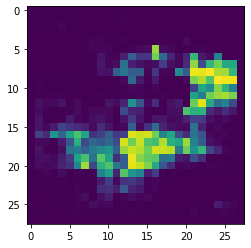

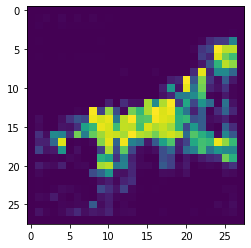

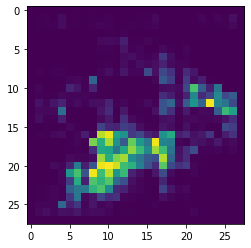

Generator loss: 29.433533
Discriminator loss: -21.155598
Step 638
Step 639
Step 640
Step 641
Step 642
Step 643
Step 644
Step 645
Step 646
Step 647
Step 648
Step 649
Step 650
Step 651
Step 652
Step 653
Step 654
Step 655
Step 656
Step 657
Step 658
Step 659
Step 660
Step 661
Step 662
Step 663
Step 664
Step 665
Step 666
Step 667
Step 668
Step 669
Step 670
Step 671
Step 672
Step 673
Step 674
Step 675
Step 676
Step 677
Step 678
Step 679
Step 680
Step 681
Step 682
Step 683
Step 684
Step 685
Step 686
Step 687
Step 688
Step 689
Step 690
Step 691
Step 692
Step 693
Step 694
Step 695


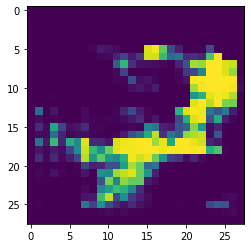

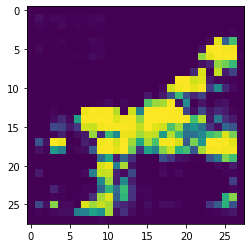

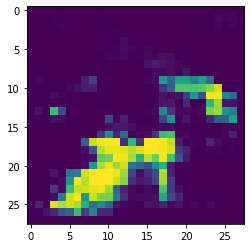

Generator loss: 79.23509
Discriminator loss: -7.5706973
Step 696
Step 697
Step 698
Step 699
Step 700
Step 701
Step 702
Step 703
Step 704
Step 705
Step 706
Step 707
Step 708
Step 709
Step 710
Step 711
Step 712
Step 713
Step 714
Step 715
Step 716
Step 717
Step 718
Step 719
Step 720
Step 721
Step 722
Step 723
Step 724
Step 725
Step 726
Step 727
Step 728
Step 729
Step 730
Step 731
Step 732
Step 733
Step 734
Step 735
Step 736
Step 737
Step 738
Step 739
Step 740
Step 741
Step 742
Step 743
Step 744
Step 745
Step 746
Step 747
Step 748
Step 749
Step 750
Step 751
Step 752
Step 753


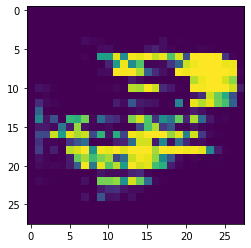

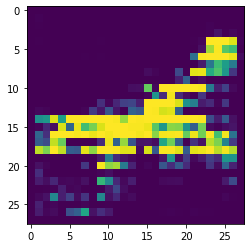

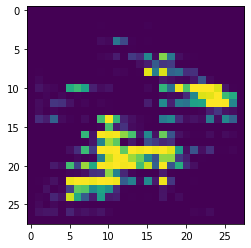

Generator loss: 29.09799
Discriminator loss: -14.634838
Step 754
Step 755
Step 756
Step 757
Step 758
Step 759
Step 760
Step 761
Step 762
Step 763
Step 764
Step 765
Step 766
Step 767
Step 768
Step 769
Step 770
Step 771
Step 772
Step 773
Step 774
Step 775
Step 776
Step 777
Step 778
Step 779
Step 780
Step 781
Step 782
Step 783
Step 784
Step 785
Step 786
Step 787
Step 788
Step 789
Step 790
Step 791
Step 792
Step 793
Step 794
Step 795
Step 796
Step 797
Step 798
Step 799
Step 800
Step 801
Step 802
Step 803
Step 804
Step 805
Step 806
Step 807
Step 808
Step 809
Step 810
Step 811


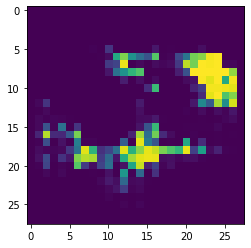

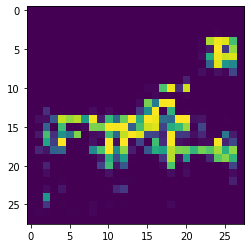

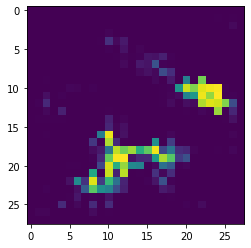

Generator loss: -11.046125
Discriminator loss: -2.9973023
Step 812
Step 813
Step 814
Step 815
Step 816
Step 817
Step 818
Step 819
Step 820
Step 821
Step 822
Step 823
Step 824
Step 825
Step 826
Step 827
Step 828
Step 829
Step 830
Step 831
Step 832
Step 833
Step 834
Step 835
Step 836
Step 837
Step 838
Step 839
Step 840
Step 841
Step 842
Step 843
Step 844
Step 845
Step 846
Step 847
Step 848
Step 849
Step 850
Step 851
Step 852
Step 853
Step 854
Step 855
Step 856
Step 857
Step 858
Step 859
Step 860
Step 861
Step 862
Step 863
Step 864
Step 865
Step 866
Step 867
Step 868
Step 869


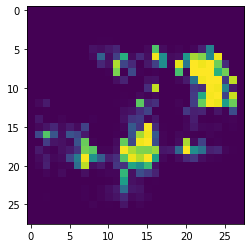

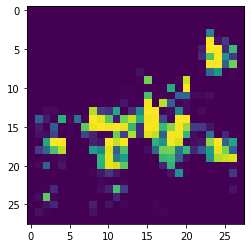

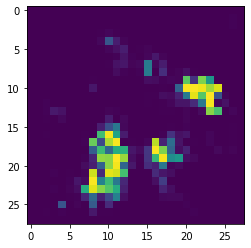

Generator loss: -4.5525866
Discriminator loss: -8.69661
Step 870
Step 871
Step 872
Step 873
Step 874
Step 875
Step 876
Step 877
Step 878
Step 879
Step 880
Step 881
Step 882
Step 883
Step 884
Step 885
Step 886
Step 887
Step 888
Step 889
Step 890
Step 891
Step 892
Step 893
Step 894
Step 895
Step 896
Step 897
Step 898
Step 899
Step 900
Step 901
Step 902
Step 903
Step 904
Step 905
Step 906
Step 907
Step 908
Step 909
Step 910
Step 911
Step 912
Step 913
Step 914
Step 915
Step 916
Step 917
Step 918
Step 919
Step 920
Step 921
Step 922
Step 923
Step 924
Step 925
Step 926
Step 927


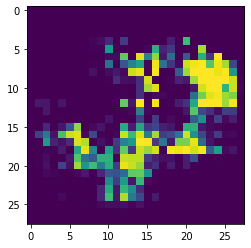

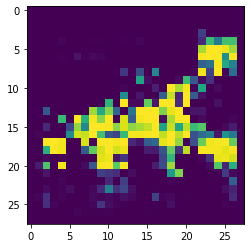

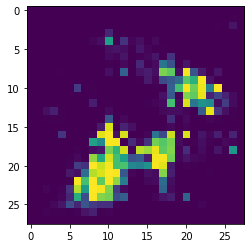

Generator loss: 12.259167
Discriminator loss: -15.968108
Step 928
Step 929


In [11]:
# Description: This part creates an object of the class Model called model and executes the training and testing of the model in the training and test loop. The training 
#              takes place over an amount of epochs (n_epochs) with a predefined learning rate. The loss function defines the kind of loss-calculation. The optimizer 
#              is needed to adjust the gradients in the training steps. Moreover, the data for the visualization of the training and test progress is collected.
#              In order to better monitor the training progress, the loss and accuracy graphs are provided in addtion to the numerical outputs when the test accuracy 
#              has significantly improved.
tf.keras.backend.clear_session()

real_images = load_real_images(5)
size_of_latent_space = 49
n_epochs = 6
n_discriminator = 1                  # How much more often the discriminator should be trained compared to the generator.
batch_size = 64
learning_rate = 0.000075

generator = Generator(size_of_latent_space)
discriminator = Discriminator()
loss_fn = tf.keras.losses.BinaryCrossentropy()                             
optimizer = tf.keras.optimizers.Adam(learning_rate)    

wasserstein = True     # True   # Decides whether a classical GAN or a Wasserstein GAN is trained.
if wasserstein == True:
  n_epochs = 10
  n_discriminator = 2                   
  learning_rate = 0.00006

  discriminator = WassersteinDiscriminator()
  loss_fn = wasserstein_loss                          
  optimizer = tf.keras.optimizers.RMSprop(learning_rate) 

bat_per_epo = int(real_images.shape[0] / batch_size)
n_steps = bat_per_epo * n_epochs
half_batch_size = int(batch_size / 2)

generator_losses = []
discriminator_losses = []

evalation_latent_spaces = generate_latent_points(size_of_latent_space, 3)
generator_evaluation_dataset = tf.data.Dataset.from_tensor_slices(evalation_latent_spaces)  
generator_evaluation_dataset = generator_evaluation_dataset.batch(3).prefetch(3)

# Training loop
for step in range(n_steps):
  print('Step ' + str(step))
  
  for i in range(n_discriminator):
    real_samples_dataset = generate_real_samples(real_images, half_batch_size, wasserstein)
    discriminator_loss_1 = discriminator_training_step(discriminator, real_samples_dataset, loss_fn, optimizer, training = True)
    discriminator_losses.append(discriminator_loss_1)         

    fake_samples_dataset = generate_fake_samples(generator, size_of_latent_space, half_batch_size, wasserstein)           
    discriminator_loss_2 = discriminator_training_step(discriminator, fake_samples_dataset, loss_fn, optimizer, training = True)                               
    discriminator_losses.append(discriminator_loss_2)     

  generator_dataset = generate_generator_samples(size_of_latent_space, batch_size, wasserstein)
  generator_loss = generator_training_step(generator, discriminator, generator_dataset,  loss_fn, optimizer, gen_training = True, dis_training = False)
  generator_losses.append(generator_loss)

  if step % 58 == 57:
    fake_imgs = []
    for input in generator_evaluation_dataset:
      fake_img = generator(input, training = False)
      fake_imgs.append(fake_img)
    for img in fake_imgs:
      plt.imshow(tf.squeeze(img[0]).numpy())
      plt.show()
      plt.imshow(tf.squeeze(img[1]).numpy())
      plt.show()
      plt.imshow(tf.squeeze(img[2]).numpy())
      plt.show()

      print("Generator loss: " + str(np.mean(generator_losses)))
      print("Discriminator loss: " + str(np.mean(discriminator_losses)))      #Diese means für spätere Visualisierung!!!
      generator_losses.clear()
      discriminator_losses.clear()